In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from music21 import corpus, converter, note
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [23]:
class BachChorales(Dataset):
    def __init__(self, seq_length=64, max_pieces=100):
        pieces = corpus.getComposer('bach')[:max_pieces]
        self.sequences = []

        all_notes = defaultdict(int)
        #self.vocab_size = 88  # MIDI pitches 0-87 (A0-C8)
        
        for piece in pieces:
            try:
                stream = corpus.parse(piece)
                notes = [max(21, min(108, n.pitch.midi)) for n in stream.flatten().notes if n.isNote]
                # Convert to 0-87 range
                notes = [n - 21 for n in notes]
                for i in range(len(notes) - seq_length):
                    self.sequences.append(notes[i:i+seq_length+1])
            except:
                continue  # Skip problematic pieces
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        x = torch.tensor(seq[:-1], dtype=torch.long)
        y = torch.tensor(seq[1:], dtype=torch.long)
        return x, y

# Create datasets
seq_length = 64  # Reduced for faster training
train_data = BachChorales(seq_length=seq_length, max_pieces=80)
val_data = BachChorales(seq_length=seq_length, max_pieces=20)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

[]
[]


In [24]:
class MusicLSTM(nn.Module):
    def __init__(self, vocab_size=88, embed_dim=16, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(out)
        return logits, hidden

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicLSTM().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 28,120


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [26]:
def train(model, epochs=20):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.view(-1, 88), targets.view(-1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs.view(-1, 88), targets.view(-1))
                val_loss += loss.item()
        
        # Calculate epoch metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
    return train_losses, val_losses

# Run training
train_losses, val_losses = train(model, epochs=15)

Epoch 1/15 | Train Loss: 2.9066 | Val Loss: 2.4362
Epoch 2/15 | Train Loss: 2.2765 | Val Loss: 2.0797
Epoch 3/15 | Train Loss: 2.0003 | Val Loss: 1.8638
Epoch 4/15 | Train Loss: 1.8114 | Val Loss: 1.7055
Epoch 5/15 | Train Loss: 1.6720 | Val Loss: 1.5943
Epoch 6/15 | Train Loss: 1.5670 | Val Loss: 1.5023
Epoch 7/15 | Train Loss: 1.4846 | Val Loss: 1.4346
Epoch 8/15 | Train Loss: 1.4178 | Val Loss: 1.3690
Epoch 9/15 | Train Loss: 1.3622 | Val Loss: 1.3160
Epoch 10/15 | Train Loss: 1.3164 | Val Loss: 1.2702
Epoch 11/15 | Train Loss: 1.2768 | Val Loss: 1.2471
Epoch 12/15 | Train Loss: 1.2441 | Val Loss: 1.2061
Epoch 13/15 | Train Loss: 1.2121 | Val Loss: 1.1779
Epoch 14/15 | Train Loss: 1.1863 | Val Loss: 1.1524
Epoch 15/15 | Train Loss: 1.1628 | Val Loss: 1.1332


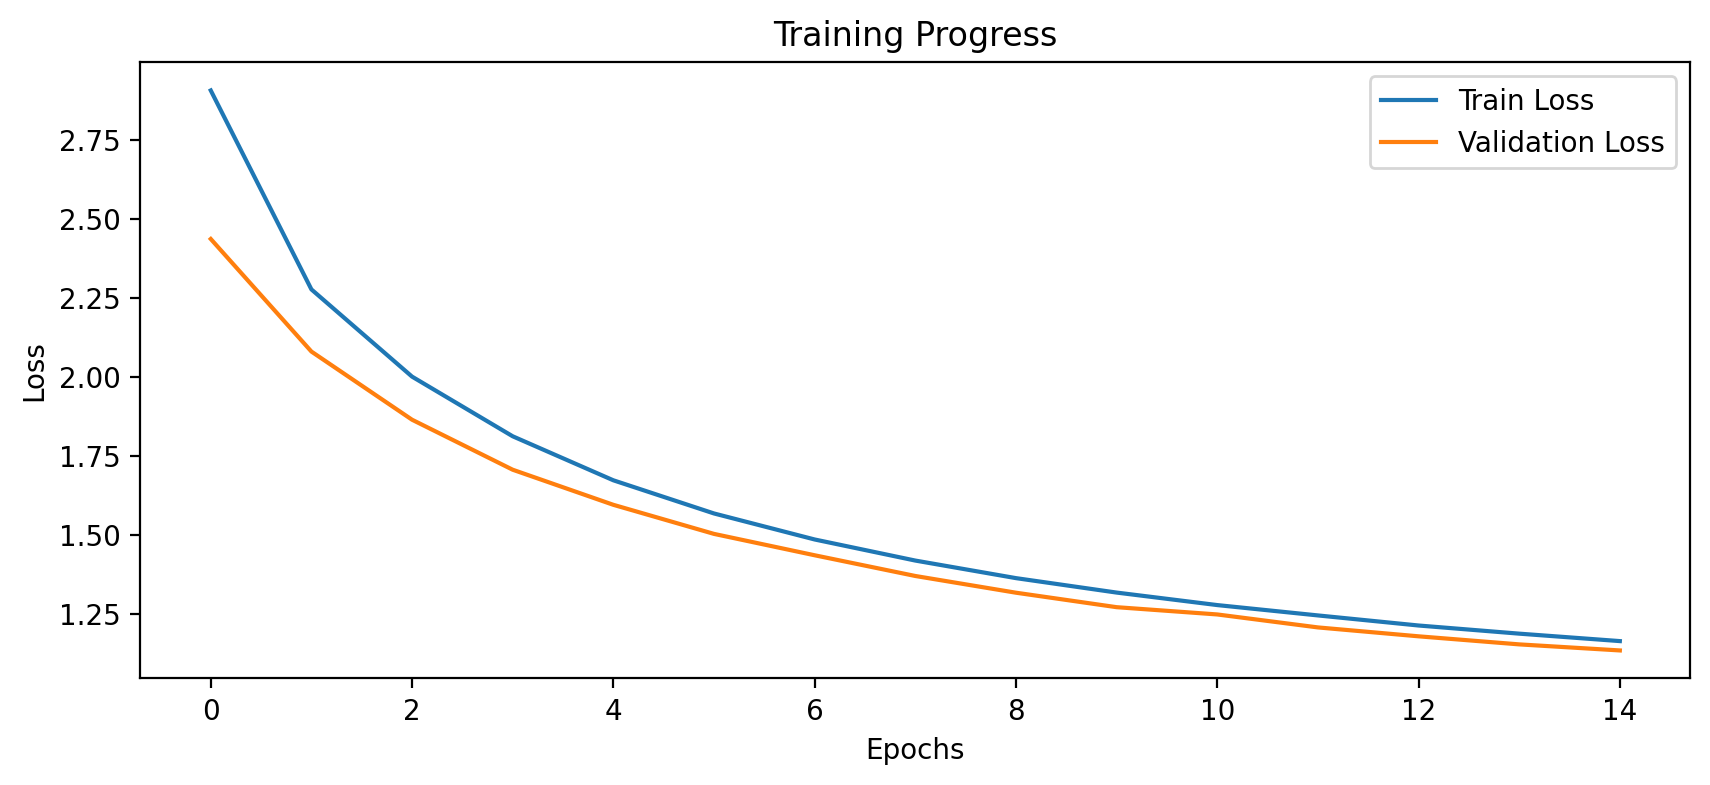

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png')

In [29]:
def generate(model, seed, seq_length, length=50, temperature=0.8):
    model.eval()
    generated = seed.copy()
    hidden = None
    
    with torch.no_grad():
        for _ in range(length):
            input_seq = torch.tensor([generated[-seq_length:]], 
                                   dtype=torch.long).to(device)
            
            output, hidden = model(input_seq, hidden)
            logits = output[0, -1] / temperature
            probabilities = torch.softmax(logits, dim=-1)
            next_note = torch.multinomial(probabilities, 1).item()
            
            generated.append(next_note)
    
    return generated

In [30]:
seed = train_data[0][0].tolist()  # First training sequence
generated_sequence = generate(model, seed, seq_length, length=50)

In [33]:
def sequence_to_midi(sequence, filename='output.mid'):
    s = converter.stream
    # Convert back to MIDI pitch (21-108)
    sequence = [n + 21 for n in sequence]
    for pitch in sequence:
        n = note.Note()
        n.pitch.midi = pitch
        s.append(n)
    s.write('midi', fp=filename)

In [34]:
sequence_to_midi(generated_sequence)

AttributeError: module 'music21.stream' has no attribute 'append'

In [7]:
print(len(all_notes))
print(len(X[0]))
print(len(y))
print(len(pieces))

433
64
85506
433
